In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pymc3 as pm

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


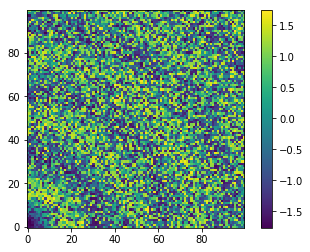

In [6]:
#Seismic displacement in two-dimensions, with frequency dependent amplitude, superposition of multiple waves instead of just a single one

#Defining main parameters of the model
rho0 = 1800 #Density of the homogeneous medium in kg/m^3, as taken from Beker's thesis paper, pg. 84
alpha = 0.31 #Parameter used in Beker's paper to determine primary wave speed pg. 84
beta = 0.25 #Parameter used in Beker's paper to determine primary wave speed pg 84.
nu = 0.25 #Poisson ratio as taken from Beker's thesis paper pg. 84

#Calculating the wave speeds using above paramters
CP = ((rho0/1000) / alpha)**(1.0 / beta) #Calculating primary wave speed using equation from Beker's paper, pg. 84
CS = np.sqrt((1-2*nu)/(2-2*nu)) * CP #Calculating secondary wave speed using equation from Beker's paper, pg. 84
Root = np.roots([1, -8, 8 * ((2 - nu)/(1 - nu)), -8 / (1 - nu)]) #Calculating the the ratio of the R wave speed to the p wave speed squared using equation found in Harm's and Beker's paper, pg. 20 in Beker's paper
for i in Root:
    if 0<i<1:
        CR = np.sqrt(CS**2 *i) #calculating R wave speed


x1_list = np.linspace(0,1000, 100) #x-positions to be evaluated
y1_list = np.linspace(0, 1000,100) #y-positions to be evaluated
t1_list = np.linspace(0, 6, 100) #time interval to be evaluated
flist = np.array([2, 4, 6, 8, 10])

f_calc_h = np.zeros(len(flist)) #array to place horizontal calculations at each frequency into
f_calc_v = np.zeros(len(flist)) #array to place vertical calculations at each frequency into


#Defining frequency dependent amplitude by estimating equation using the amplitude spectral density graph in Beker's thesis paper on pg. 100
def A(f):
    return (1.0 / 2**(-2.72)) * f**(-2.72)

#Calculating seismic displacement using equation from Harm's paper "Terrestial Gravity Fluctuations", pg. 31 
def xi_horiz(x, y, z, t, f, theta, phi):
    omega = 2*np.pi*f #calculating the angular frequency
    ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
    ke_vec = [np.cos(theta) * ke, np.sin(theta) * ke] #Rayleigh wave vector in x-y plane
    ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
    kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
    q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
    q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
    zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
    return (ke * np.exp(q_z_p * z) - zeta * np.exp(q_z_s * z)) * np.sin(np.dot(ke_vec, [x,y]) - omega * t + phi)

def xi_vert(x, y, z, t, f, theta, phi):
    omega = 2*np.pi*f #calculating the angular frequency
    ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
    ke_vec = [np.cos(theta) * ke, np.sin(theta) * ke] #Rayleigh wave vector in x-y plane
    ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
    kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
    q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
    q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
    zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
    return (q_z_p * np.exp(q_z_p * z) - zeta * ke * np.exp(q_z_s * z)) * np.cos(np.dot(ke_vec, [x,y]) - omega * t + phi)

#Defining functions to calculate the superposition of the displacement due to multiple waves with different parameters
def xi_horiz_sp(x, y, z, t): #superposition of the horizontal components of various Rayleigh waves at different frequencies and phases
    for i, fn in enumerate(flist):
        theta = np.random.uniform(-np.pi/2, np.pi/2) #letting each frequency have a random direction of propagation, in the positive x-direction
        omega = 2*np.pi*fn #calculating the angular frequency
        ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
        ke_vec = [np.cos(theta) * ke, np.sin(theta) * ke] #Rayleigh wave vector in x-y plane
        ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
        kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
        q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
        q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
        zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
        phi = np.pi / fn #letting each frequency have a different phase shift
        f_calc_h[i] = A(fn) * (ke * np.exp(q_z_p * z) - zeta * np.exp(q_z_s * z)) * np.sin(np.dot(ke_vec, [x,y]) - omega * t + phi) #calculating the horizontal displacement of each wave
    xi_horiz_sp = np. sum(f_calc_h)
    return xi_horiz_sp

def xi_vert_sp(x, y, z, t): #superposition of the vertical components of various Rayleigh waves with different frequencies and phases
    for i, fn in enumerate(flist):
        theta = np.random.uniform(-np.pi/2, np.pi/2) #letting each frequency have a random direction of propagation, in the positive x-direction
        omega = 2*np.pi*fn #calculating the angular frequency
        ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
        ke_vec = [np.cos(theta) * ke, np.sin(theta) * ke] #Rayleigh wave vector in x-y plane
        ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
        kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
        q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
        q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
        zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
        phi = np.pi / fn #letting each frequency have a different phase shift
        f_calc_v[i] = A(fn) * (q_p_z * np.exp(q_p_z * z) - sigma * k_e * np.exp(q_s_z * z)) * np.cos(np.dot(k_e_vec, [x,y]) - omega * t + phi) #calculating the vertical displacement of each wave
    xi_vert_sp = np.sum(f_calc_v)
    return xi_vert_sp

H = np.zeros((len(x1_list), len(y1_list)))
for i, xn in enumerate(x1_list):
    for j, yn in enumerate(y1_list):
        H[i,j] = xi_horiz_sp(xn, yn, 0, 0)
        
fig3 = plt.imshow(H, cmap='viridis', origin='lower')
plt.colorbar()

In [3]:
#Model to calculate the Seismic Newtonian Noise using the displacement model above still needs to be built